In [2]:
# Install SQL Alchemy
!pip install -q SQLAlchemy==1.3.13


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
redshift_schema = "redshift"
redshift_cluster_identifier = "amazonreviewscluster"
redshift_host = "amazonreviewscluster"
redshift_database = "amazon_reviews_capstone"
redshift_port = "5439"
redshift_table_2015 = "amazon_reviews_tsv_2015"
redshift_table_2014 = "amazon_reviews_tsv_2014"

In [97]:
import json
import boto3

secretsmanager = boto3.client("secretsmanager")

secret = secretsmanager.get_secret_value(SecretId="dsoaws_redshift_login")
cred = json.loads(secret["SecretString"])

redshift_username = cred[0]["username"]
redshift_pw = cred[1]["password"]

In [95]:
redshift = boto3.client("redshift")

response = redshift.describe_clusters(ClusterIdentifier=redshift_cluster_identifier)

redshift_endpoint_address = response["Clusters"][0]["Endpoint"]["Address"]

print(redshift_endpoint_address)

amazonreviewscluster.cqj1po1m4uti.us-east-1.redshift.amazonaws.com


In [7]:
import awswrangler as wr

con_redshift = wr.data_api.redshift.connect(
    cluster_id=redshift_cluster_identifier,
    database=redshift_database,
    db_user=redshift_username,
)


In [8]:
%%time
df = wr.data_api.redshift.read_sql_query(
    sql="""SELECT approximate count(distinct customer_id)
                        FROM {}.{}
                        GROUP BY product_category""".format(
        redshift_schema, redshift_table_2015
    ),
    con=con_redshift,
)

CPU times: user 45.4 ms, sys: 6.6 ms, total: 52 ms
Wall time: 8.88 s


In [9]:
%%time
df = wr.data_api.redshift.read_sql_query(
    sql="""SELECT count(distinct customer_id)
                                FROM {}.{}
                                GROUP BY product_category""".format(
            redshift_schema, redshift_table_2015
    ),
    con=con_redshift,
)

CPU times: user 27 ms, sys: 201 µs, total: 27.2 ms
Wall time: 5.7 s


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [20]:
statement = """
SELECT product_category,
COUNT(star_rating) AS count_star_rating
FROM {}.{}
GROUP BY product_category
ORDER BY count_star_rating DESC
""".format(
    redshift_schema, redshift_table_2014
)

print(statement)


SELECT product_category,
COUNT(star_rating) AS count_star_rating
FROM redshift.amazon_reviews_tsv_2014
GROUP BY product_category
ORDER BY count_star_rating DESC



In [21]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)

In [22]:
df.head()

,product_category,count_star_rating
0,Digital_Ebook_Purchase,7236359
1,Books,3710219
2,Wireless,2842708
3,Mobile_Apps,2241375
4,Apparel,2122511


In [23]:
num_categories = df.shape[0]
print(num_categories)

43


In [24]:
max_ratings = df["count_star_rating"].max()
print(max_ratings)

7236359


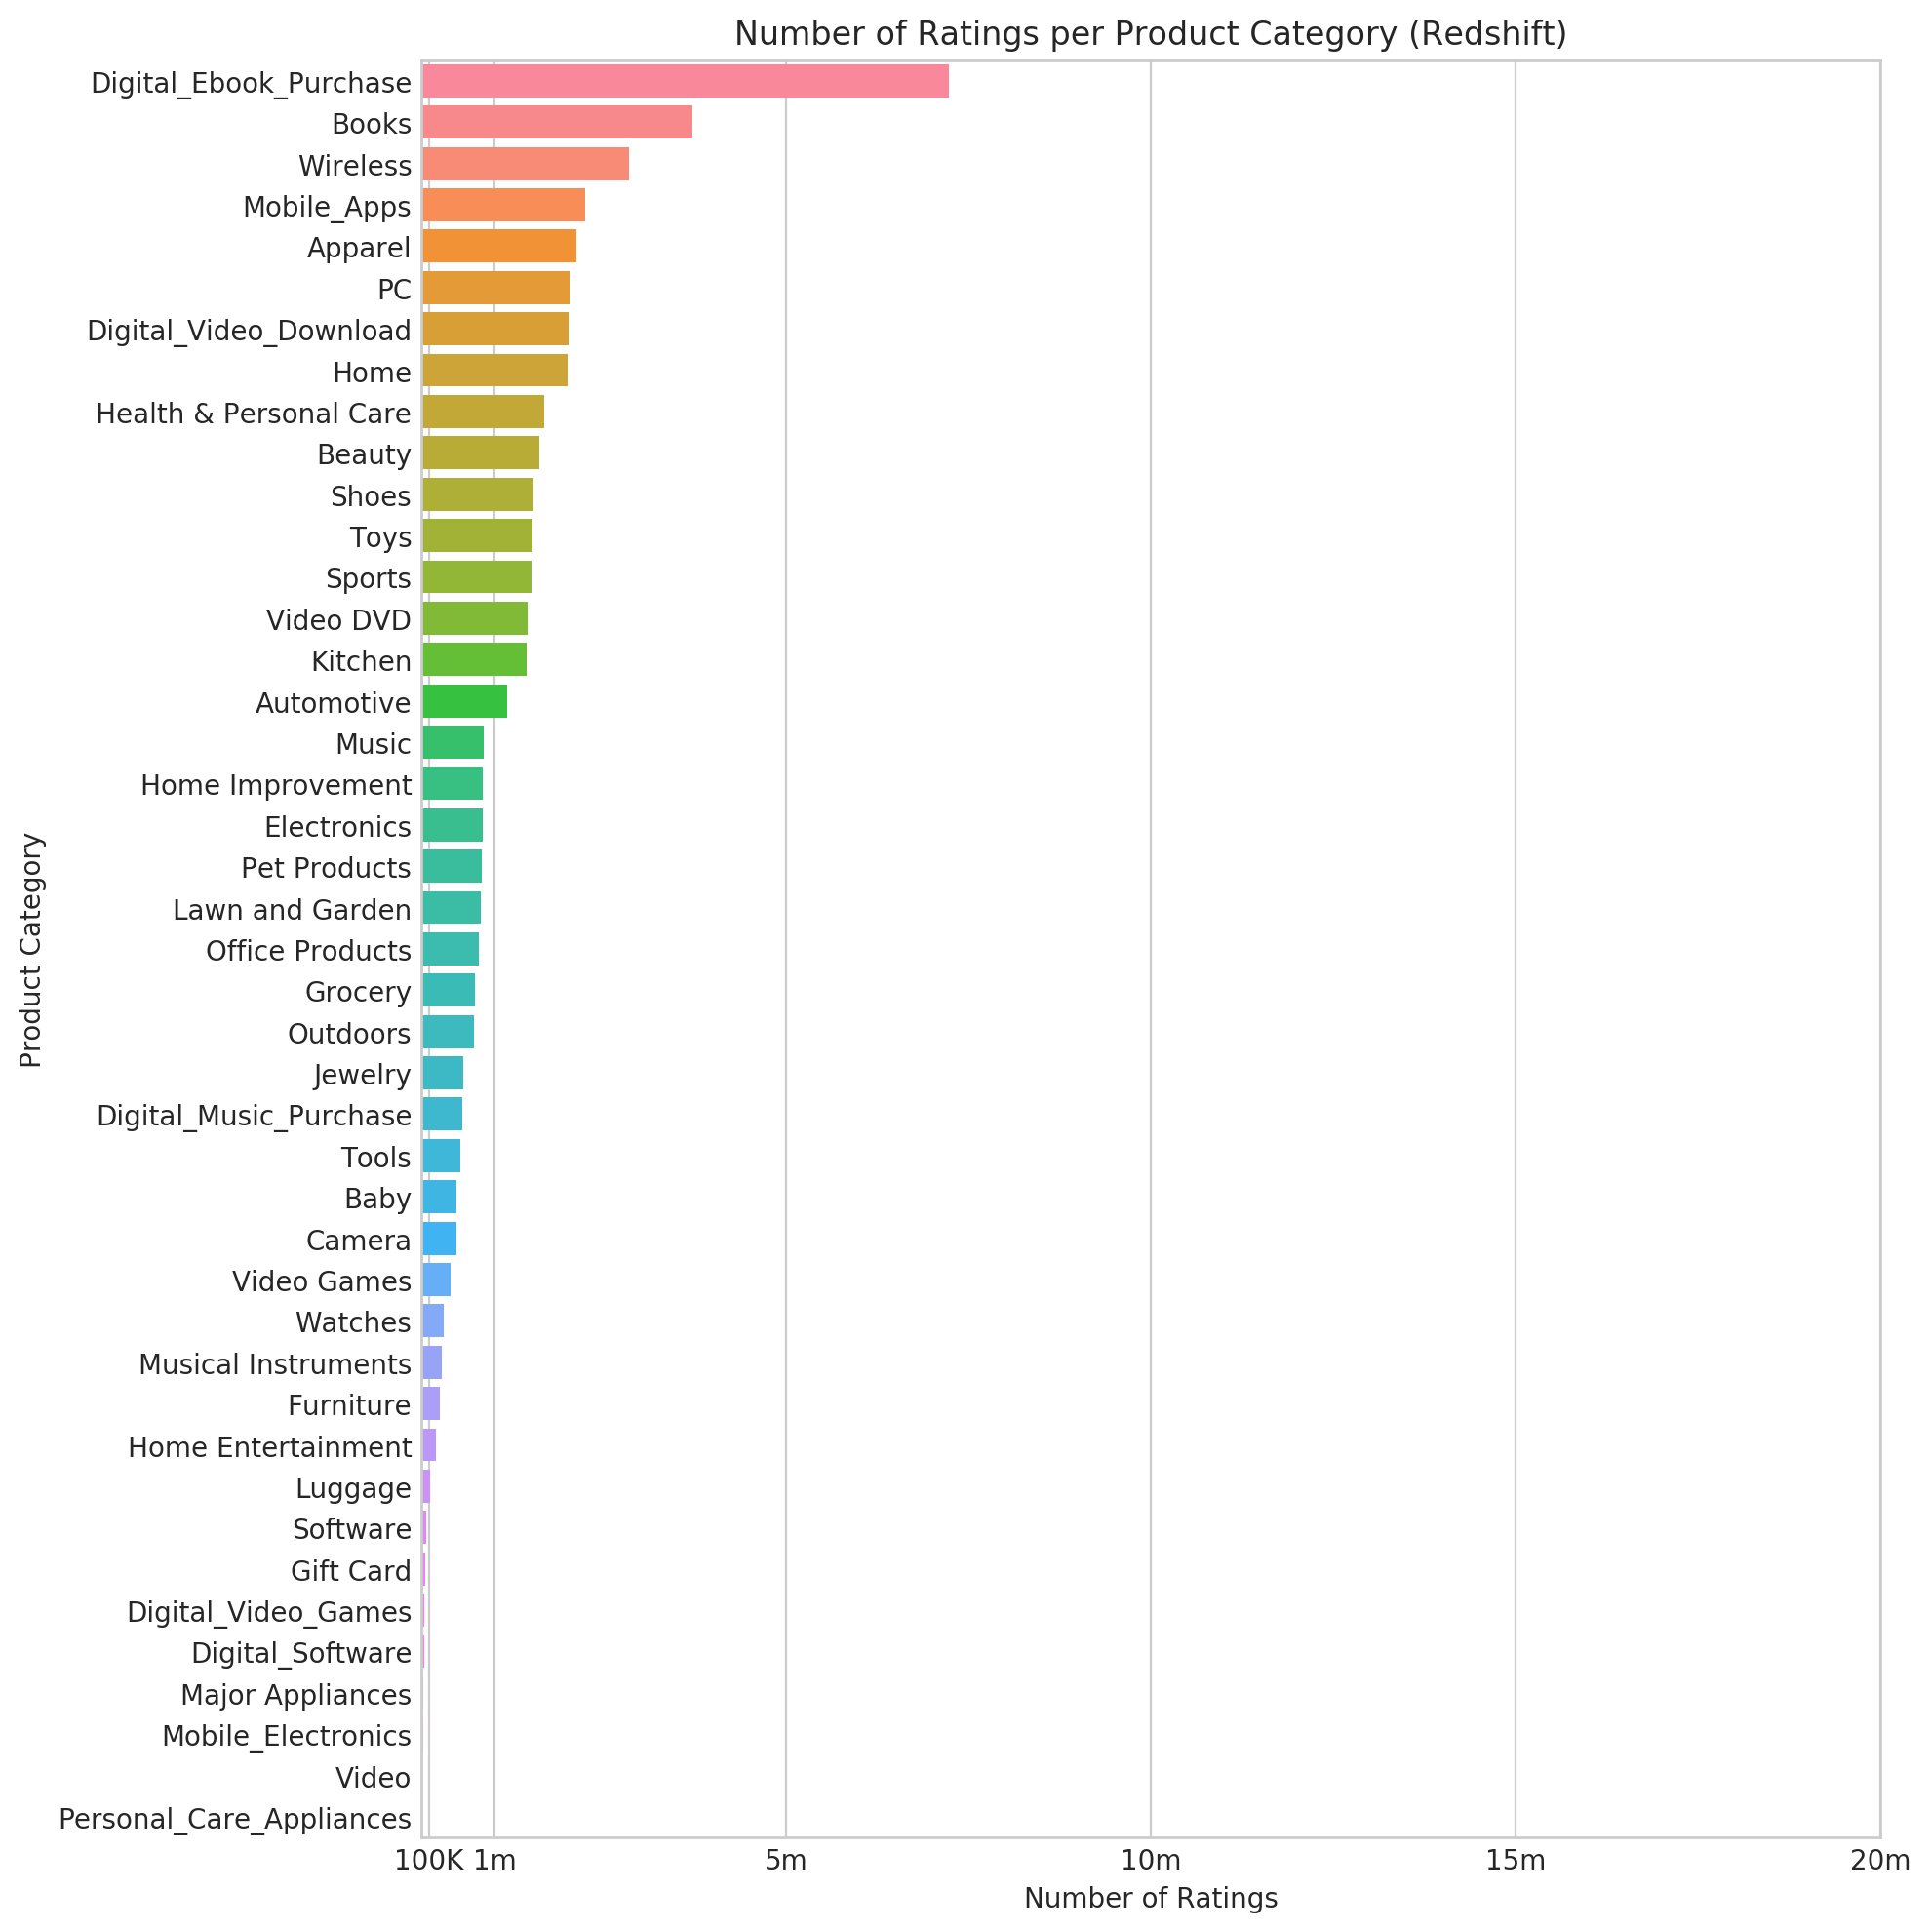

In [25]:
if num_categories > 10:
    plt.figure(figsize=(10, 10))
else:
    plt.figure(figsize=(10, 5))

plt.style.use("seaborn-whitegrid")

# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category (Redshift)")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
if max_ratings <= 8000:
    plt.xticks(
        [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000],
        ["10K", "20K", "30K", "40K", "50K", "60K", "70K", "80K"],
    )
    plt.xlim(0, 80000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "1500K", "200K"])
    plt.xlim(0, 200000)
elif max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

In [26]:
def show_vb(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

In [30]:
statement = """
SELECT
    year,
    product_category,
    COUNT(star_rating) AS count_star_rating   
FROM
    {}.{}  
GROUP BY
    product_category,
    year  
ORDER BY
    count_star_rating DESC,
    year DESC
""".format(redshift_schema, redshift_table_2014)

print(statement)


SELECT
    year,
    product_category,
    COUNT(star_rating) AS count_star_rating   
FROM
    redshift.amazon_reviews_tsv_2014  
GROUP BY
    product_category,
    year  
ORDER BY
    count_star_rating DESC,
    year DESC



In [31]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)

In [32]:
df

,year,product_category,count_star_rating
0,2014,Digital_Ebook_Purchase,7236359
1,2014,Books,3710219
2,2014,Wireless,2842708
3,2014,Mobile_Apps,2241375
4,2014,Apparel,2122511
5,2014,PC,2024830
6,2014,Digital_Video_Download,2018029
7,2014,Home,2001632
8,2014,Health & Personal Care,1682989
9,2014,Beauty,1610983


In [33]:
count_ratings = df['count_star_rating']

num_categories = df['product_category'].count()
print(num_categories)

max_ratings = df['count_star_rating'].max()
print(max_ratings)

min_ratings = df['count_star_rating'].min()
print(min_ratings)

43
7236359
16540


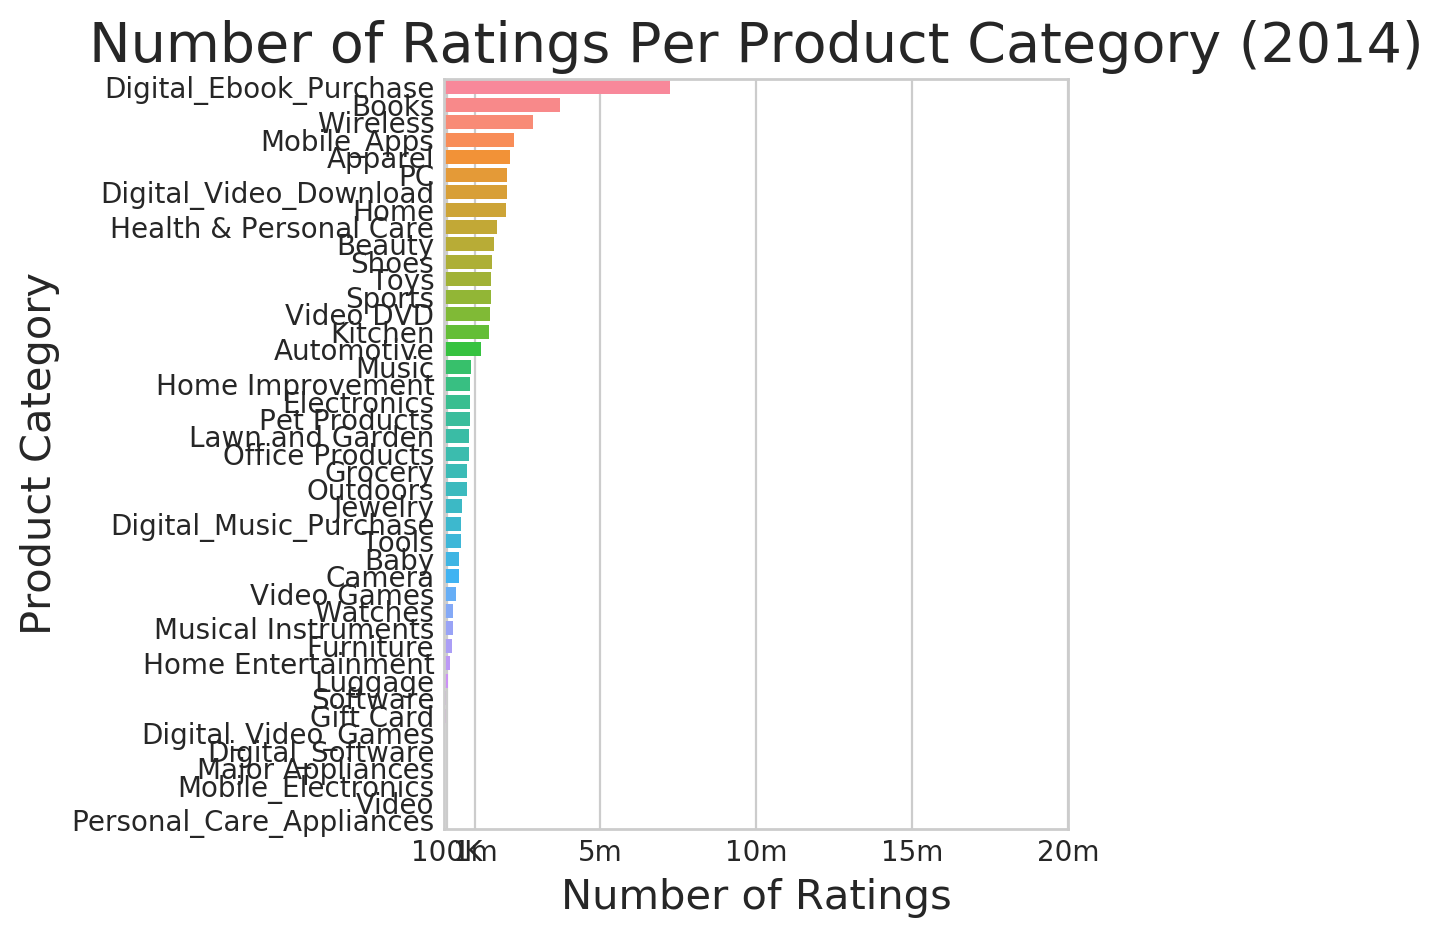

In [40]:
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

# Scale if needed
if num_categories > 10:
        sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'figure.figsize':(5.0, 7.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':3})
    
# Set title
barplot.set_title("Number of Ratings Per Product Category (2014)", fontsize="20")

# Set x-axis ticks to match scale 
if max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '150K', '200K'])
    plt.xlim(0, 200000)
elif max_ratings <= 5000000:
    plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000], ['1m', '2m', '3m', '4m', '5m'])
    plt.xlim(0, 5000000)
else:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)

plt.xlabel("Number of Ratings", fontsize="15")
plt.ylabel("Product Category", fontsize="15")

plt.tight_layout()


# Show the barplot
plt.show(barplot)

In [53]:
statement = """
SELECT
    product_title,
    product_category,
    helpful_votes,
    LENGTH(review_body) AS review_body_length,
    SUBSTRING(review_body, 1, 100) AS review_body_substring 
FROM
    {}.{} 
ORDER BY
    helpful_votes DESC LIMIT 10 
""".format(redshift_schema, redshift_table_2014)

print(statement)


SELECT
    product_title,
    product_category,
    helpful_votes,
    LENGTH(review_body) AS review_body_length,
    SUBSTRING(review_body, 1, 100) AS review_body_substring 
FROM
    redshift.amazon_reviews_tsv_2014 
ORDER BY
    helpful_votes DESC LIMIT 10 



In [55]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)

In [56]:
df

,product_title,product_category,helpful_votes,review_body_length,review_body_substring
0,"Kindle, 6"" Glare-Free Touchscreen Display",PC,16982,4180,I've had this Kindle for a while now. Many of ...
1,Kindle Voyage,PC,13557,16383,[[VIDEOID:ce7f727e612026a1ea2062912719ef84]] [...
2,Honeywell Home/Bldg Center RTH9580WF1005/W1 Wi...,Home Improvement,13267,2674,My former wife loves to take expensive vacatio...
3,Fire HD 6,PC,11444,9072,If you read my Fire TV review you know that I ...
4,"Haribo Gummi Candy Gold-Bears,",Grocery,11045,1746,I didn't feel the need to plan my weekend arou...
5,"Kindle, 6"" Glare-Free Touchscreen Display",PC,10683,7506,"As has been the case for years, Amazon sloooow..."
6,Instant Pot IP-DUO60 7-in-1 Multi-Functional P...,Kitchen,9369,5322,"Over the years, I have purchased hundreds of i..."
7,"Fire HD 6 Kids Edition, 6"" HD Display, Wi-Fi, ...",PC,7991,7483,As a family who owns multiple Fires in differe...
8,Samsung UN105S9 Curved 105-Inch 4K Ultra HD 12...,Home Entertainment,7564,269,I was able to purchase this amazing television...
9,Canon Office and Business MX922 All in One Pri...,Office Products,6832,5434,This is my first review on any product on Amaz...


In [48]:
statement = """
SELECT
    product_category,
    COUNT(star_rating) AS count_stars,
    AVG(star_rating::FLOAT) AS avg_star_rating
FROM
    {}.{}  
GROUP BY
    product_category  
ORDER BY
    avg_star_rating DESC
""".format(redshift_schema, redshift_table_2014)

print(statement)


SELECT
    product_category,
    COUNT(star_rating) AS count_stars,
    AVG(star_rating::FLOAT) AS avg_star_rating
FROM
    redshift.amazon_reviews_tsv_2014  
GROUP BY
    product_category  
ORDER BY
    avg_star_rating DESC



In [49]:
df_average_rating = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)

In [50]:
df_average_rating

,product_category,count_stars,avg_star_rating
0,Gift Card,47186,4.745772
1,Digital_Music_Purchase,556776,4.668738
2,Music,858430,4.578789
3,Video DVD,1458990,4.498225
4,Books,3710219,4.472028
5,Video,18646,4.418696
6,Digital_Ebook_Purchase,7236359,4.335754
7,Grocery,729228,4.330308
8,Tools,533995,4.294527
9,Musical Instruments,277201,4.270504


In [62]:
statement = """
SELECT
    product_category,
    star_rating,
    COUNT(DISTINCT review_id) AS count_reviews 
FROM
    {}.{} 
GROUP BY
    product_category,
    star_rating 
ORDER BY
    product_category ASC,
    star_rating DESC,
    count_reviews
""".format(redshift_schema, redshift_table_2014)

print(statement)



SELECT
    product_category,
    star_rating,
    COUNT(DISTINCT review_id) AS count_reviews 
FROM
    redshift.amazon_reviews_tsv_2014 
GROUP BY
    product_category,
    star_rating 
ORDER BY
    product_category ASC,
    star_rating DESC,
    count_reviews



In [63]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)

In [64]:
df


,product_category,star_rating,count_reviews
0,Apparel,5,1176632
1,Apparel,4,428515
2,Apparel,3,231807
3,Apparel,2,134693
4,Apparel,1,150808
...,...,...,...
210,Wireless,5,1555317
211,Wireless,4,461121
212,Wireless,3,250715
213,Wireless,2,178989


In [68]:
gc = df.groupby('product_category')
gs = df.groupby('star_rating')
df_sum = df.groupby(['star_rating']).sum()
total = df_sum['count_reviews'].sum()
print(total)

44883845


In [70]:
dist = {}
count_reviews_per_star = []
i=0
    
for category, ratings in gc:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.at[i, 'count_reviews'])
        i=i+1;
    dist[category] = count_reviews_per_star
print(dist)

{'Apparel': [1176632, 428515, 231807, 134693, 150808], 'Automotive': [777525, 174409, 79710, 48033, 95885], 'Baby': [299966, 74685, 40967, 26002, 36289], 'Beauty': [1032650, 229117, 125735, 82101, 141365], 'Books': [2540498, 524941, 228406, 109790, 138585], 'Camera': [290831, 81317, 35900, 21896, 40875], 'Digital_Ebook_Purchase': [4105272, 1520231, 592753, 250440, 257415], 'Digital_Music_Purchase': [422336, 61441, 18251, 6862, 13423], 'Digital_Software': [19745, 5852, 2458, 1892, 6798], 'Digital_Video_Download': [964623, 304209, 133166, 74630, 111044], 'Digital_Video_Games': [25791, 5602, 3330, 2204, 6827], 'Electronics': [500092, 136794, 63197, 45431, 92274], 'Furniture': [145220, 48730, 23431, 13650, 22500], 'Gift Card': [41245, 3153, 925, 459, 1404], 'Grocery': [509189, 87439, 49196, 31079, 52322], 'Health & Personal Care': [1063691, 244450, 127542, 86696, 160189], 'Home': [1273709, 301445, 160648, 100437, 164915], 'Home Entertainment': [98569, 30992, 14421, 10176, 21719], 'Home Imp

In [71]:
print(dist.keys())

dict_keys(['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift Card', 'Grocery', 'Health & Personal Care', 'Home', 'Home Entertainment', 'Home Improvement', 'Jewelry', 'Kitchen', 'Lawn and Garden', 'Luggage', 'Major Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical Instruments', 'Office Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video DVD', 'Video Games', 'Watches', 'Wireless'])


In [72]:
print(dist.items())

dict_items([('Apparel', [1176632, 428515, 231807, 134693, 150808]), ('Automotive', [777525, 174409, 79710, 48033, 95885]), ('Baby', [299966, 74685, 40967, 26002, 36289]), ('Beauty', [1032650, 229117, 125735, 82101, 141365]), ('Books', [2540498, 524941, 228406, 109790, 138585]), ('Camera', [290831, 81317, 35900, 21896, 40875]), ('Digital_Ebook_Purchase', [4105272, 1520231, 592753, 250440, 257415]), ('Digital_Music_Purchase', [422336, 61441, 18251, 6862, 13423]), ('Digital_Software', [19745, 5852, 2458, 1892, 6798]), ('Digital_Video_Download', [964623, 304209, 133166, 74630, 111044]), ('Digital_Video_Games', [25791, 5602, 3330, 2204, 6827]), ('Electronics', [500092, 136794, 63197, 45431, 92274]), ('Furniture', [145220, 48730, 23431, 13650, 22500]), ('Gift Card', [41245, 3153, 925, 459, 1404]), ('Grocery', [509189, 87439, 49196, 31079, 52322]), ('Health & Personal Care', [1063691, 244450, 127542, 86696, 160189]), ('Home', [1273709, 301445, 160648, 100437, 164915]), ('Home Entertainment', 

In [74]:
sorted_dist = {}

df_average_rating.iloc[:,0]
for index, value in df_average_rating.iloc[:,0].items():
    sorted_dist[value] = dist[value]

sorted_dist

{'Gift Card': [41245, 3153, 925, 459, 1404],
 'Digital_Music_Purchase': [422336, 61441, 18251, 6862, 13423],
 'Music': [561173, 96869, 40912, 16918, 20069],
 'Video DVD': [898571, 164216, 73752, 34429, 53782],
 'Books': [2540498, 524941, 228406, 109790, 138585],
 'Video': [12446, 2319, 1244, 517, 985],
 'Digital_Ebook_Purchase': [4105272, 1520231, 592753, 250440, 257415],
 'Grocery': [509189, 87439, 49196, 31079, 52322],
 'Tools': [347439, 88264, 37696, 21549, 36757],
 'Musical Instruments': [175997, 46692, 20039, 11625, 19505],
 'Automotive': [777525, 174409, 79710, 48033, 95885],
 'Toys': [982131, 217280, 114848, 66956, 115277],
 'Kitchen': [947442, 210030, 103147, 66951, 113664],
 'Outdoors': [455358, 126595, 56418, 33917, 49257],
 'Shoes': [925731, 300051, 144093, 84966, 75492],
 'Sports': [964041, 253266, 117810, 69682, 109047],
 'Digital_Video_Download': [964623, 304209, 133166, 74630, 111044],
 'Luggage': [70376, 19460, 9155, 5742, 8064],
 'Home Improvement': [541036, 131389, 60

In [75]:
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_dist.keys():
    stars = sorted_dist.get(k)
    star5.append(stars[0])
    star4.append(stars[1])
    star3.append(stars[2])
    star2.append(stars[3])
    star1.append(stars[4])

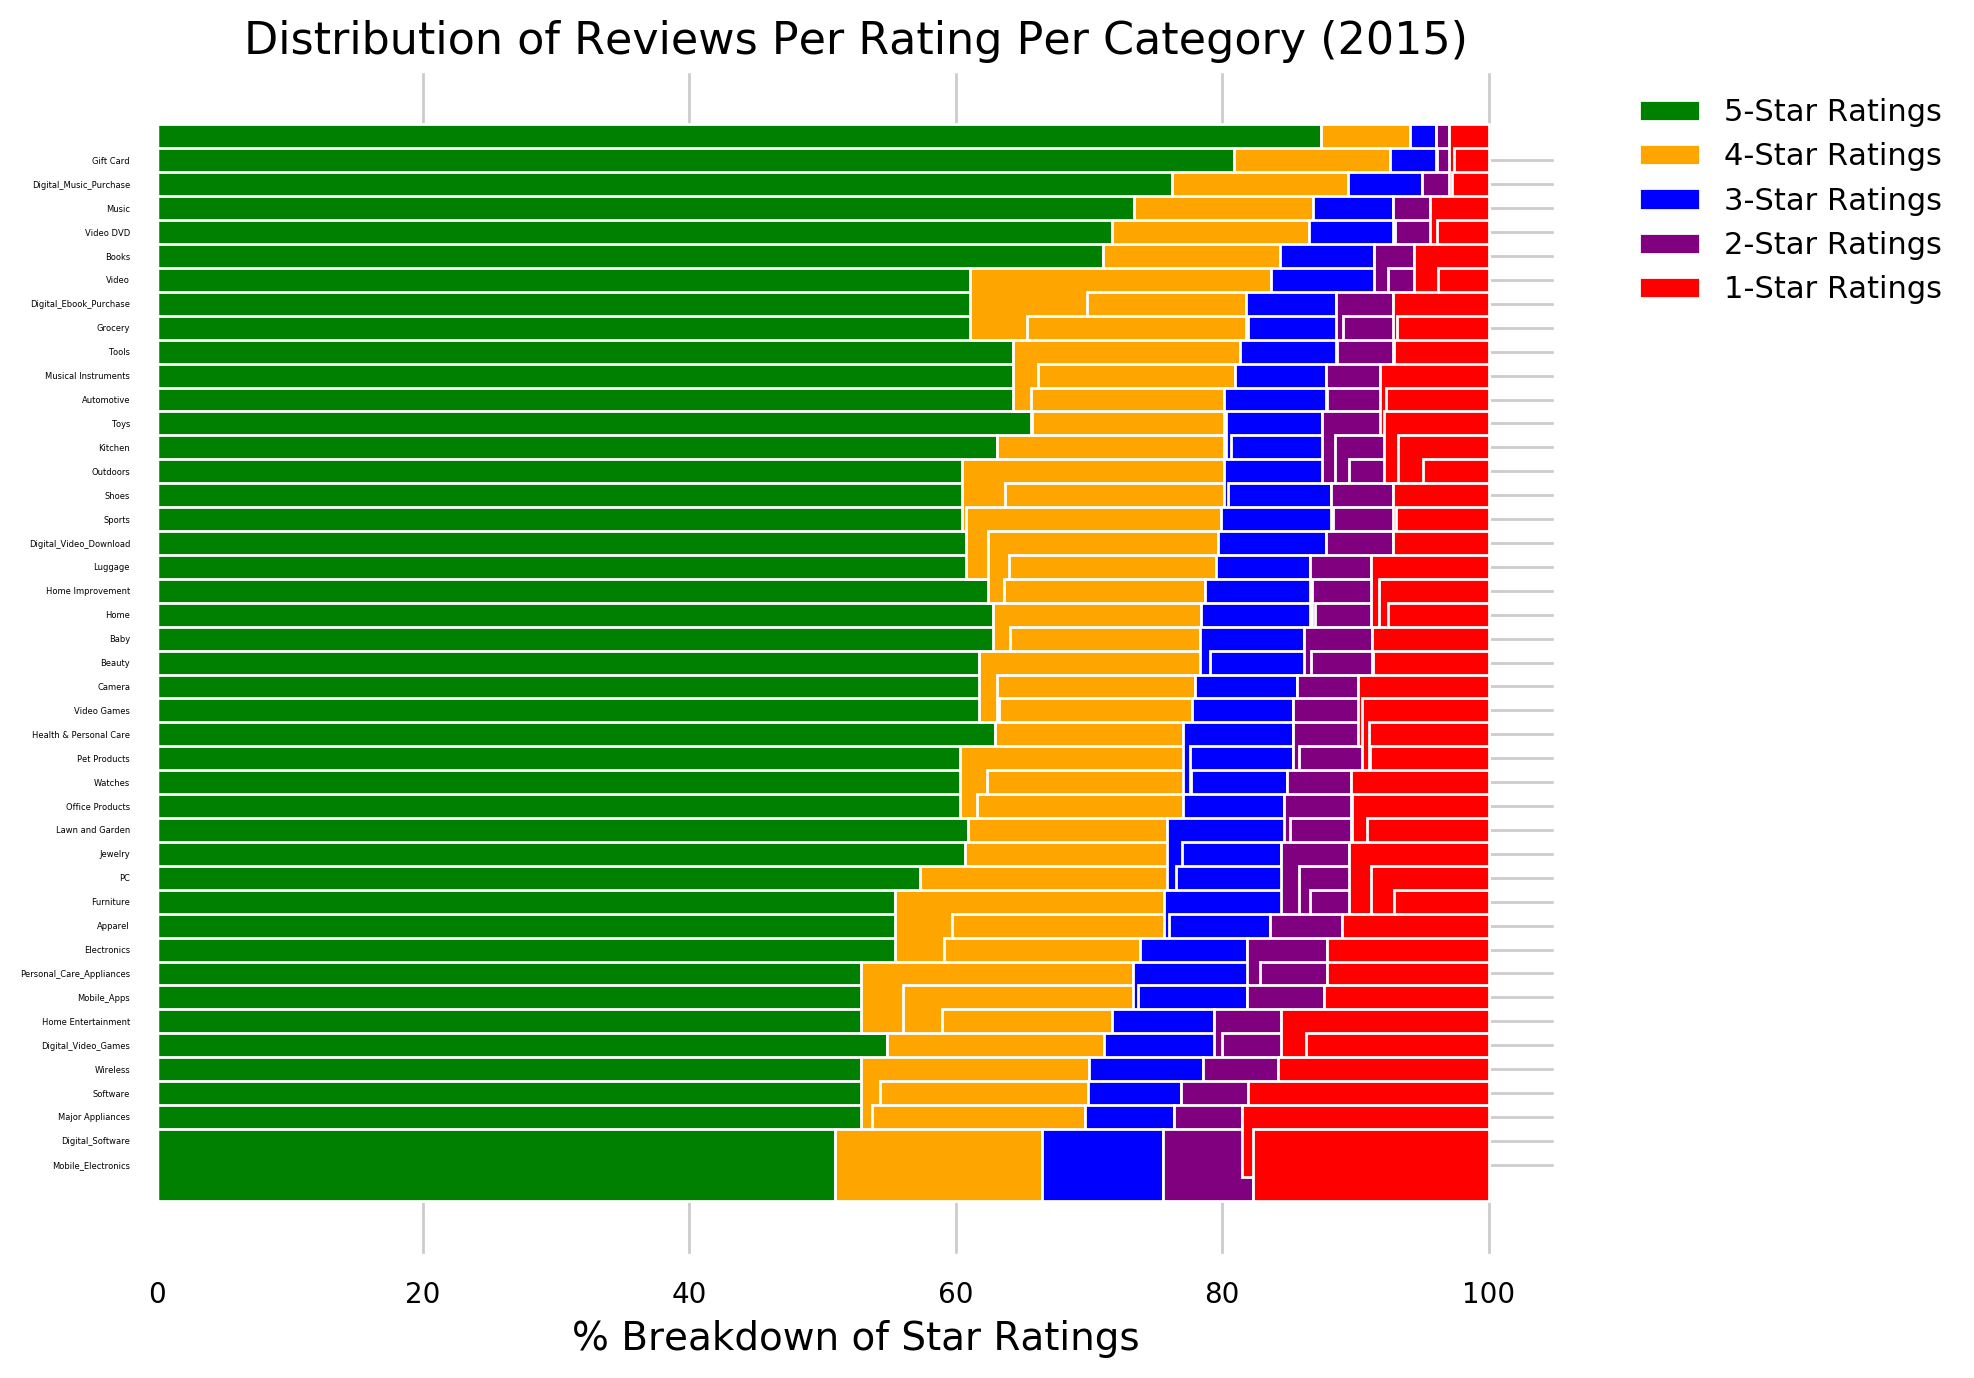

In [79]:
categories = sorted_dist.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 3

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,7))
else: 
    plt.figure(figsize=(10,7))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category (2015)",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='regular')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('redshift_2015_proportion_star_per_category.png', dpi=300)
plt.show()

In [81]:
statement = """
SELECT
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    {}.{} 
GROUP BY
    month
ORDER BY
    month
""".format(redshift_schema, redshift_table_2014)

print(statement)


SELECT
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    redshift.amazon_reviews_tsv_2014 
GROUP BY
    month
ORDER BY
    month



In [82]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)
df

,month,avg_rating
0,1,4.209282
1,2,4.199495
2,3,4.206166
3,4,4.203848
4,5,4.205448
5,6,4.201416
6,7,4.252561
7,8,4.259770
8,9,4.253988
9,10,4.254602


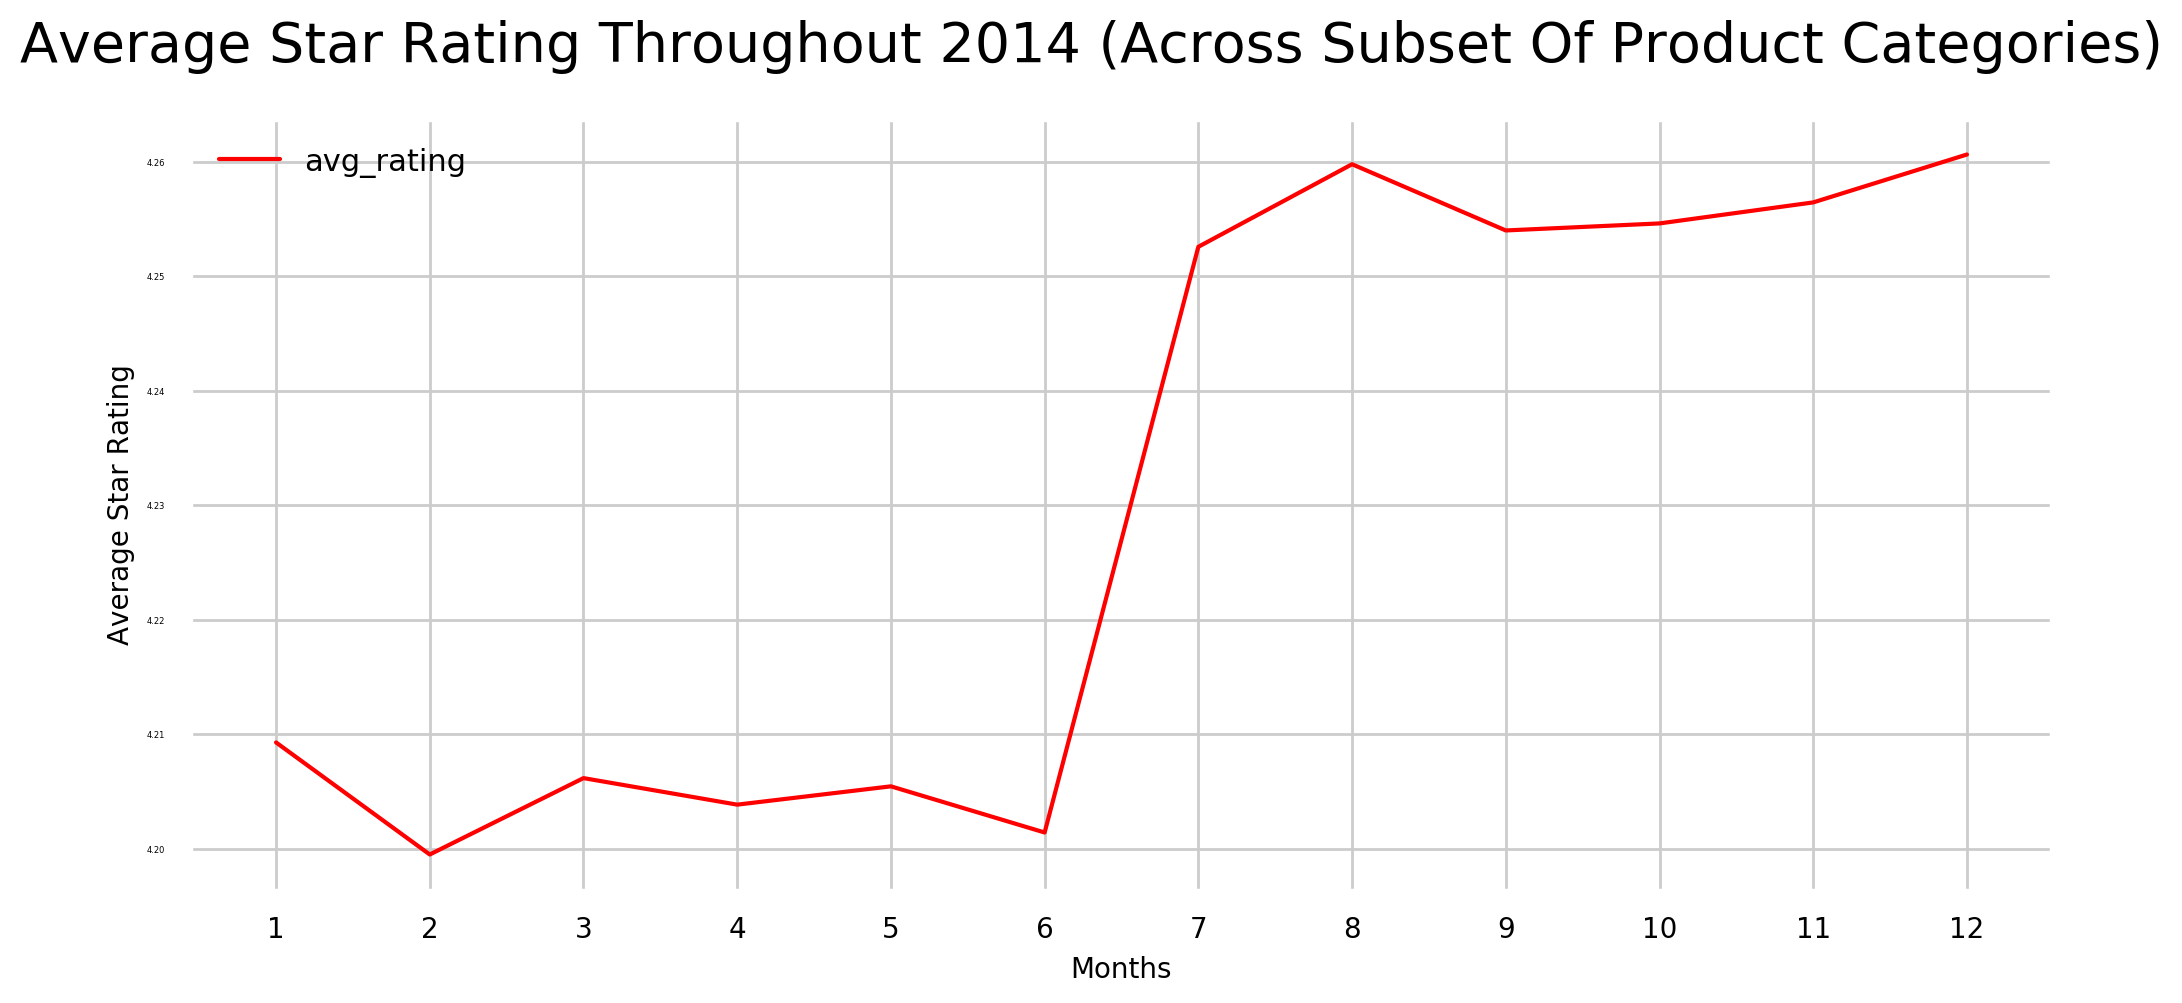

In [85]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Throughout 2014 (Across Subset Of Product Categories)')

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df['month'].unique())

df.plot(kind='line',x='month',y='avg_rating', color='red', ax=ax)

plt.xlabel('Months')
plt.ylabel('Average Star Rating')

plt.show()

In [86]:
statement = """
SELECT
    product_category,
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    {}.{} 
GROUP BY
    product_category, month
ORDER BY
    product_category, month
""".format(redshift_schema, redshift_table_2014)

print(statement)


SELECT
    product_category,
    CAST(DATE_PART('month', TO_DATE(review_date, 'YYYY-MM-DD')) AS INTEGER) AS month,
    AVG(star_rating::FLOAT) AS avg_rating  
FROM
    redshift.amazon_reviews_tsv_2014 
GROUP BY
    product_category, month
ORDER BY
    product_category, month



In [87]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)
df

,product_category,month,avg_rating
0,Apparel,1,4.115109
1,Apparel,2,4.076638
2,Apparel,3,4.052242
3,Apparel,4,4.050652
4,Apparel,5,4.046716
...,...,...,...
511,Wireless,8,3.951473
512,Wireless,9,3.955090
513,Wireless,10,3.971295
514,Wireless,11,4.000965


In [88]:
def plot_categories(df):
    df_categories = df['product_category'].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df['product_category'] == category]
        df_plot.plot(kind='line',x='month',y='avg_rating', c=np.random.rand(3,), ax=ax, label=category)

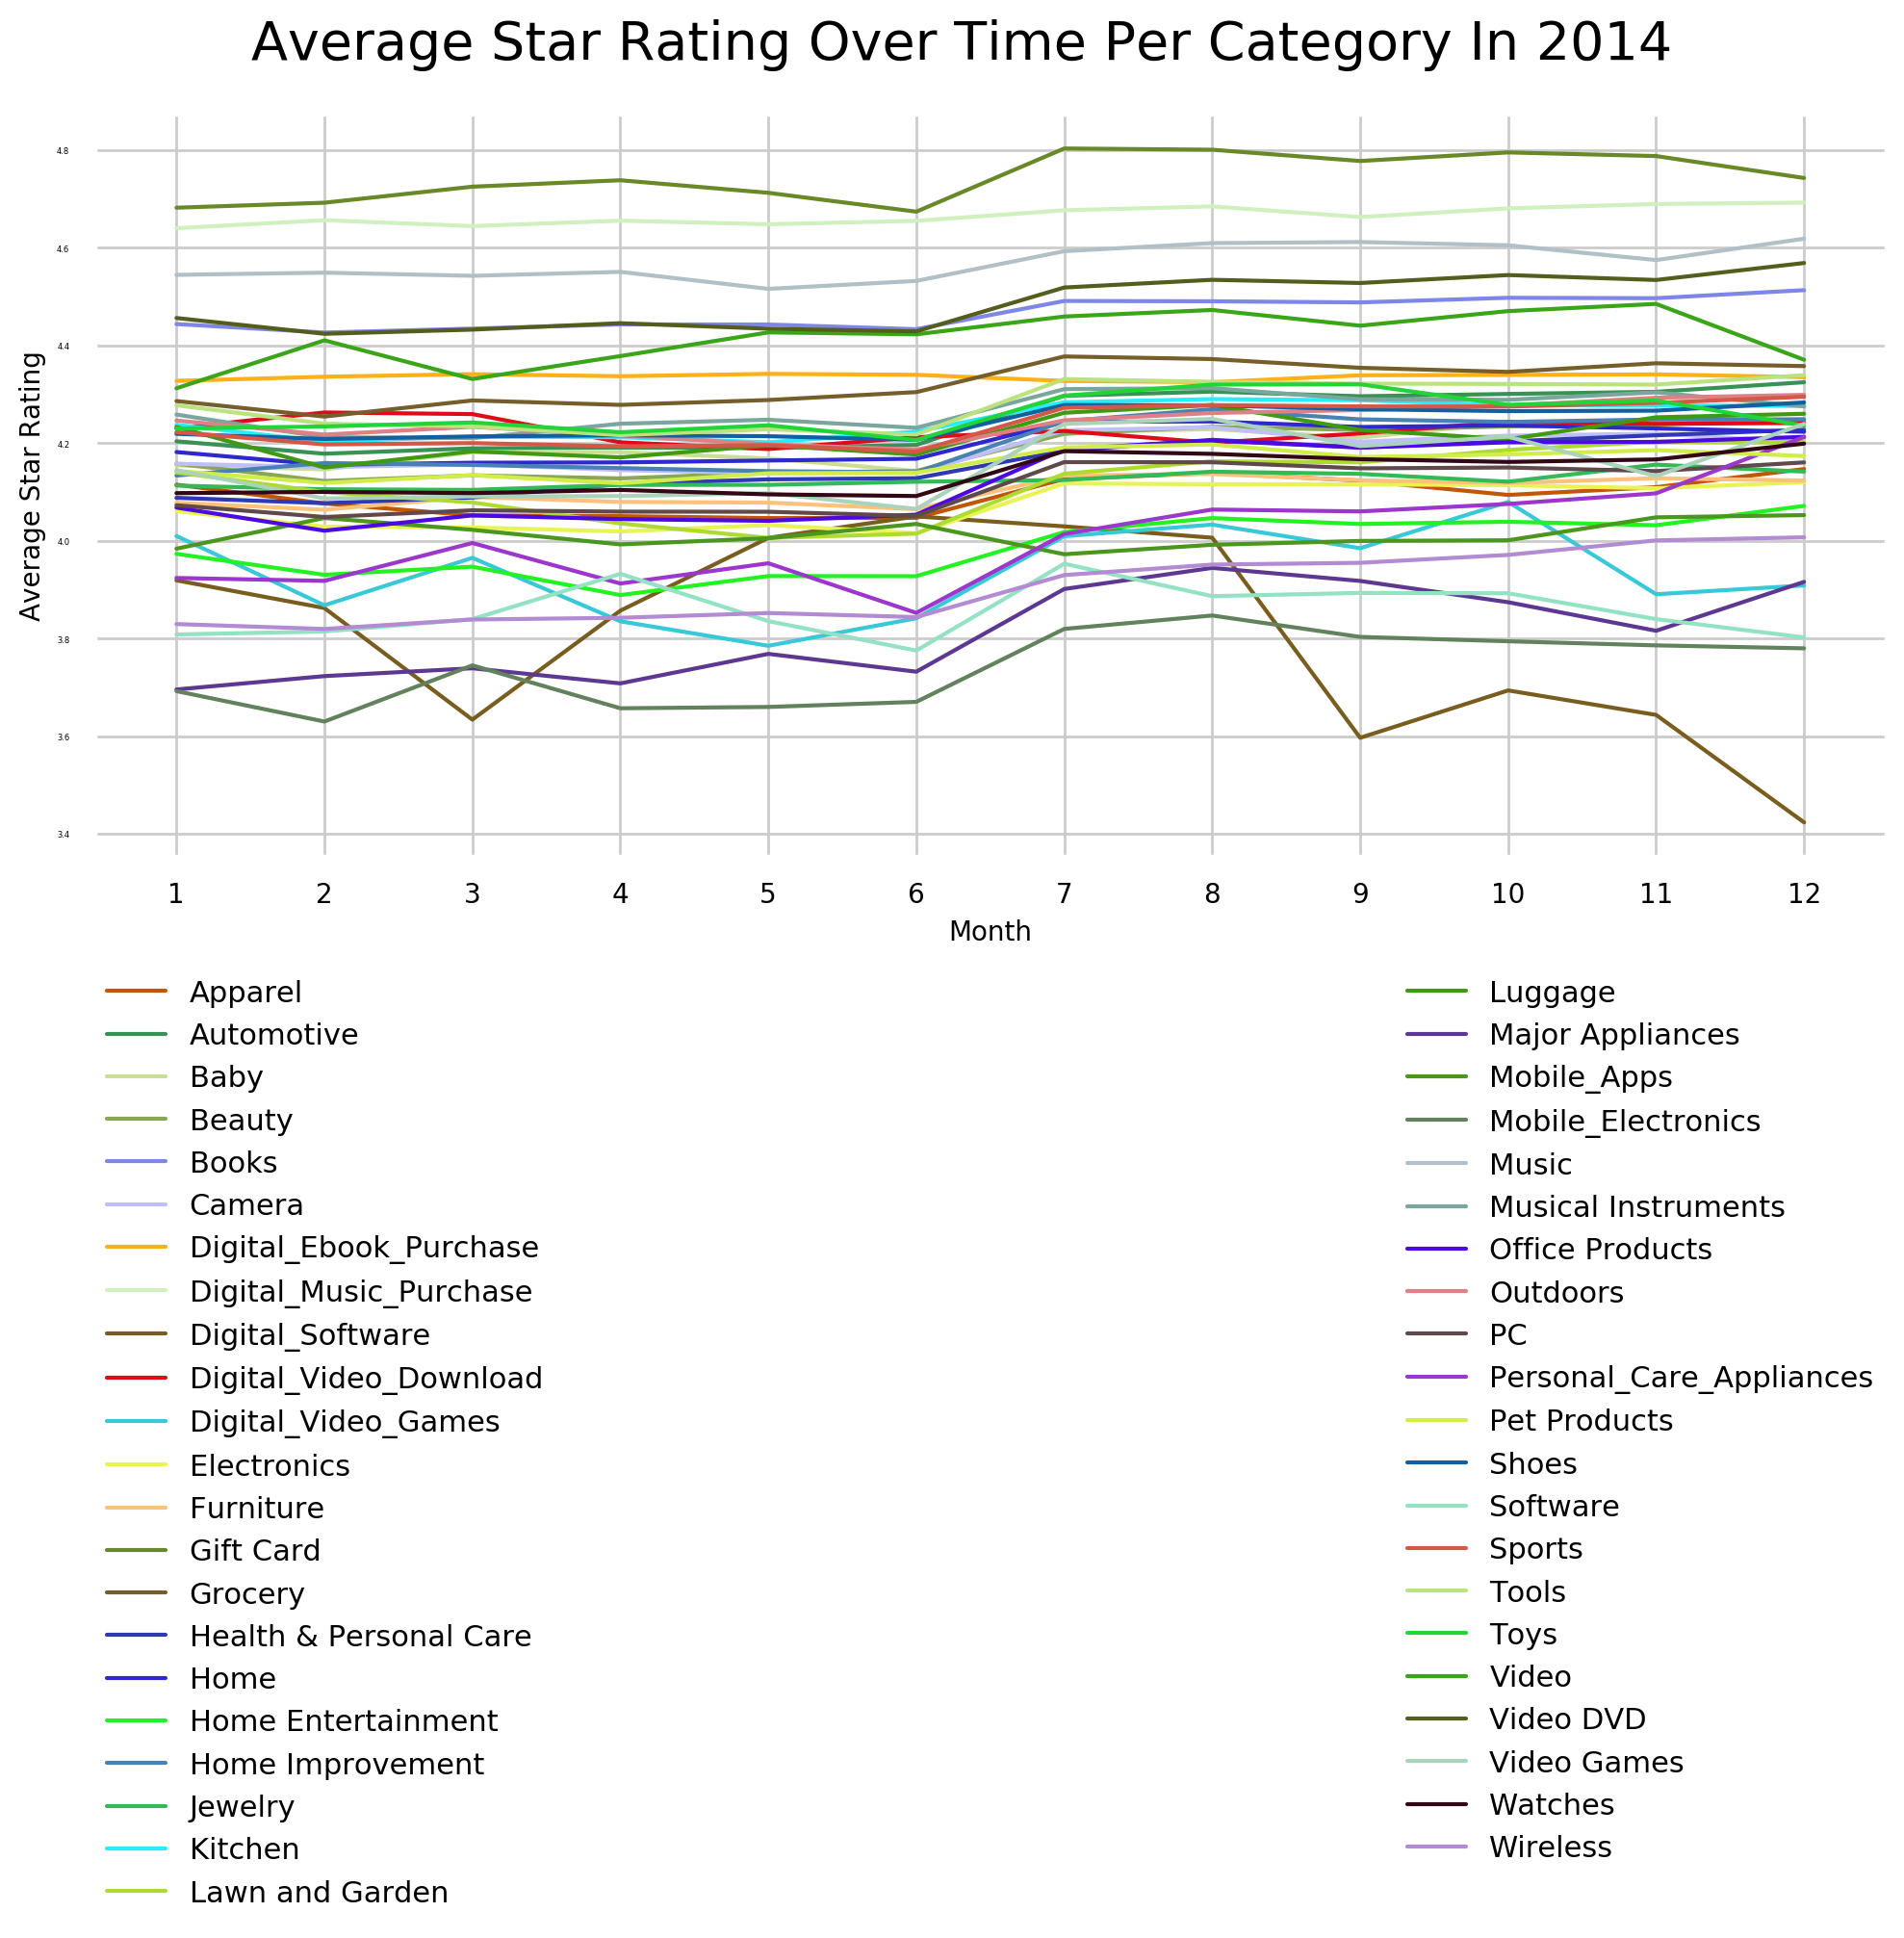

In [89]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Over Time Per Category In 2014')
           
ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df['month'].unique())

plot_categories(df)

plt.xlabel('Month')
plt.ylabel('Average Star Rating')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)
plt.show()

In [92]:
statement = """
SELECT
    customer_id,
    product_category,
    product_title,
    ROUND(AVG(star_rating::FLOAT), 4) AS avg_star_rating,
    COUNT(*) AS review_count  
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    customer_id,
    product_category,
    product_title  
HAVING
    COUNT(*) > 1  
ORDER BY
    review_count DESC LIMIT 5 
""".format(redshift_schema, redshift_table_2014)

print(statement)


SELECT
    customer_id,
    product_category,
    product_title,
    ROUND(AVG(star_rating::FLOAT), 4) AS avg_star_rating,
    COUNT(*) AS review_count  
FROM
    redshift.amazon_reviews_tsv_2015 
GROUP BY
    customer_id,
    product_category,
    product_title  
HAVING
    COUNT(*) > 1  
ORDER BY
    review_count DESC LIMIT 5 



In [93]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift,
)
df

,customer_id,product_category,product_title,avg_star_rating,review_count
